In [1]:
import numpy as np
import h5py
import scipy.fft as sf
import grand.sim.detector.rf_chain2 as grfc
from grand import grand_add_path_data
import grand.manage_log as mlg
import matplotlib.pyplot as plt

#########################################################
def interp(x,y,z):
    return np.interp(x,y,z)
#########################################################

def Compute_S_ABCD_matrix_db(filename):
    element = grfc.Rfchain_elements_db(filename=filename) #If the components of the .s2p file are in deciBel
    #element = grfc.Rfchain_elements(filename="cable+Connector.s2p") #If the components of the .s2p file are in complex numbers
    element.compute_for_freqs(freq_MHz)
    S_matrix1 = np.stack([element.s11[0], element.s12[0], element.s21[0], element.s22[0]], axis=1)
    #The S matrix of the RF_chain element: S_matrix[:,0,0] = s11, S_matrix[:,0,1] = s12, S_matrix[:,1,0] = s21, S_matrix[:,1,1] = s22
    S_matrix = np.reshape(S_matrix1, (290, 2, 2)) #The S matrix of the RF_chain element 
    ABCD_matrix1 = np.stack([element.ABCD_matrix[0,0,0,:], element.ABCD_matrix[0,1,0,:], element.ABCD_matrix[1,0,0,:], element.ABCD_matrix[1,1,0,:]], axis=1)
    ABCD_matrix = np.reshape(ABCD_matrix1, (290, 2, 2)) #The ABCD matrix of the RF_chain element
    return S_matrix, ABCD_matrix

###########################################################
def Compute_S_ABCD_matrix_db_rad(filename):
    element = grfc.Rfchain_elements_db_rad(filename=filename) #If the components of the .s2p file are in deciBel
    #element = grfc.Rfchain_elements(filename="cable+Connector.s2p") #If the components of the .s2p file are in complex numbers
    element.compute_for_freqs(freq_MHz)
    S_matrix1 = np.stack([element.s11[0], element.s12[0], element.s21[0], element.s22[0]], axis=1)
    #The S matrix of the RF_chain element: S_matrix[:,0,0] = s11, S_matrix[:,0,1] = s12, S_matrix[:,1,0] = s21, S_matrix[:,1,1] = s22
    S_matrix = np.reshape(S_matrix1, (290, 2, 2)) #The S matrix of the RF_chain element 
    ABCD_matrix1 = np.stack([element.ABCD_matrix[0,0,0,:], element.ABCD_matrix[0,1,0,:], element.ABCD_matrix[1,0,0,:], element.ABCD_matrix[1,1,0,:]], axis=1)
    ABCD_matrix = np.reshape(ABCD_matrix1, (290, 2, 2)) #The ABCD matrix of the RF_chain element
    return S_matrix, ABCD_matrix
#########################################################

def Compute_S_ABCD_matrix(filename):
    element = grfc.Rfchain_elements(filename=filename) #If the components of the .s2p file are in complex numbers
    element.compute_for_freqs(freq_MHz)
    S_matrix1 = np.stack([element.s11[0], element.s12[0], element.s21[0], element.s22[0]], axis=1)
    #The S matrix of the RF_chain element: S_matrix[:,0,0] = s11, S_matrix[:,0,1] = s12, S_matrix[:,1,0] = s21, S_matrix[:,1,1] = s22
    S_matrix = np.reshape(S_matrix1, (290, 2, 2)) #The S matrix of the RF_chain element 
    ABCD_matrix1 = np.stack([element.ABCD_matrix[0,0,0,:], element.ABCD_matrix[0,1,0,:], element.ABCD_matrix[1,0,0,:], element.ABCD_matrix[1,1,0,:]], axis=1)
    #The ABCD matrix of the RF_chain element: ABCD_matrix[:,0,0] = a11, ABCD_matrix[:,0,1] = a12, ABCD_matrix[:,1,0] = a21, ABCD_matrix[:,1,1] = a22
    ABCD_matrix = np.reshape(ABCD_matrix1, (290, 2, 2)) #The ABCD matrix of the RF_chain element
    return S_matrix, ABCD_matrix
#############################################################

def Compute_S_ABCD_matrix_rad(filename):
    element = grfc.Rfchain_elements_rad(filename=filename) #If the components of the .s2p file are in complex numbers
    element.compute_for_freqs(freq_MHz)
    S_matrix1 = np.stack([element.s11[0], element.s12[0], element.s21[0], element.s22[0]], axis=1)
    #The S matrix of the RF_chain element: S_matrix[:,0,0] = s11, S_matrix[:,0,1] = s12, S_matrix[:,1,0] = s21, S_matrix[:,1,1] = s22
    S_matrix = np.reshape(S_matrix1, (290, 2, 2)) #The S matrix of the RF_chain element 
    ABCD_matrix1 = np.stack([element.ABCD_matrix[0,0,0,:], element.ABCD_matrix[0,1,0,:], element.ABCD_matrix[1,0,0,:], element.ABCD_matrix[1,1,0,:]], axis=1)
    #The ABCD matrix of the RF_chain element: ABCD_matrix[:,0,0] = a11, ABCD_matrix[:,0,1] = a12, ABCD_matrix[:,1,0] = a21, ABCD_matrix[:,1,1] = a22
    ABCD_matrix = np.reshape(ABCD_matrix1, (290, 2, 2)) #The ABCD matrix of the RF_chain element
    return S_matrix, ABCD_matrix

#########################################################
#Calculate the load impedance providing the element .s1p file
def Load_impedance(filename):
    element = grfc.Zload_arb(filename=filename)
    element.compute_for_freqs(freq_MHz)
    return element.Z_load
###########################################################

def Ant_impedance(filename):
    Zant_dat = np.loadtxt(grand_add_path_data(os.path.join("detector", "RFchain_v2", filename)), delimiter=",", comments=['#', '!'], skiprows=1)
    freqs_in = Zant_dat[:,0]  # MHz
    ZantX=interp(freq_MHz,Zant_dat[:,0],Zant_dat[:,1])+1j*interp(freq_MHz,Zant_dat[:,0],Zant_dat[:,2])
    ZantY=interp(freq_MHz,Zant_dat[:,0],Zant_dat[:,3])+1j*interp(freq_MHz,Zant_dat[:,0],Zant_dat[:,4])
    ZantZ=interp(freq_MHz,Zant_dat[:,0],Zant_dat[:,5])+1j*interp(freq_MHz,Zant_dat[:,0],Zant_dat[:,6])
    return ZantX, ZantY, ZantZ
#########################################################

def from_ABCD_to_S(ABCD_matrix,Z0):
    #normalize port 1 and port 2 to Z0
    a=np.zeros((len(freqs),2,2),dtype='complex')    
    div = ABCD_matrix[:,0,0] + ABCD_matrix[:,0,1]/Z0 + ABCD_matrix[:,1,0]*Z0 + ABCD_matrix[:,1,1]
    a[:,0,0]=(ABCD_matrix[:,0,0] + ABCD_matrix[:,0,1]/Z0 - ABCD_matrix[:,1,0]*Z0 - ABCD_matrix[:,1,1]) /div
    a[:,0,1]=2*(ABCD_matrix[:,0,0]*ABCD_matrix[:,1,1]-ABCD_matrix[:,1,0]*ABCD_matrix[:,0,1])/div
    a[:,1,0]=2/div
    a[:,1,1]=(-ABCD_matrix[:,0,0]+ABCD_matrix[:,0,1]/Z0- ABCD_matrix[:,1,0]*Z0 +ABCD_matrix[:,1,1]) /div
    return a

#########################################################

def from_S_to_ABCD(S_Matrix,Z01,Z02):    
    a=np.zeros((len(freqs),2,2),dtype='complex')
    a[:,0,0]=((1+S_Matrix[:,0,0])*(1-S_Matrix[:,1,1])+S_Matrix[:,0,1]*S_Matrix[:,1,0]) / (2*S_Matrix[:,1,0])
    a[:,0,1]=((1+S_Matrix[:,0,0])*(1+S_Matrix[:,1,1])-S_Matrix[:,0,1]*S_Matrix[:,1,0]) / (2*S_Matrix[:,1,0])
    a[:,1,0]=((1-S_Matrix[:,0,0])*(1-S_Matrix[:,1,1])-S_Matrix[:,0,1]*S_Matrix[:,1,0]) / (2*S_Matrix[:,1,0])
    a[:,1,1]=((1-S_Matrix[:,0,0])*(1+S_Matrix[:,1,1])+S_Matrix[:,0,1]*S_Matrix[:,1,0]) / (2*S_Matrix[:,1,0])
    factor=np.array([[1/np.sqrt(Z02/Z01),np.sqrt(Z01*Z02)],[1/np.sqrt(Z01*Z02),1/np.sqrt(Z01/Z02)]]) #to denormalize a
    return a*factor

#########################################################

def from_S_to_TF(S_Matrix,ZLoad,Zant,Z01,Z02):
    Gant=(Zant-Z01)/(Zant+Z01)
    GLoad=(ZLoad-Z02)/(ZLoad+Z02)
    Gin=S_Matrix[:,0,0]+(S_Matrix[:,0,1]*S_Matrix[:,1,0])/(1-S_Matrix[:,1,1]*GLoad)
    Voc=1
    Vout=Voc*0.5*(1-Gant)/(1-Gin*Gant)*S_Matrix[:,1,0]*(GLoad+1)/(1-S_Matrix[:,1,1]*GLoad)
    return Vout

#########################################################

def from_ABCD_to_TF(ABCD_matrix,ABCD_bis,ZLoad,Zant):
    Zin=(ABCD_matrix[:,0,0]*ZLoad+ABCD_matrix[:,0,1])/(ABCD_matrix[:,1,0]*ZLoad+ABCD_matrix[:,1,1])
    Voc=1
    I1=Voc/(Zin+Zant)
    V1=I1*Zin
    V1I1=np.zeros((len(freqs),2,1),dtype='complex')
    V1I1[:,0,0]=V1
    V1I1[:,1,0]=I1
    invABCD=np.linalg.inv(ABCD_matrix)
    invABCDbis=np.linalg.inv(ABCD_bis)
    V2=np.matmul(invABCD,V1I1)[:,0,0]
    I2=np.matmul(invABCD,V1I1)[:,1,0]
    V2balun=np.matmul(invABCDbis,V1I1)[:,0,0]
    I2balun=np.matmul(invABCDbis,V1I1)[:,1,0]
    return V2,V2balun,I2

#########################################################

def plotSmatrix(sMatrix,title=''):
    plt.plot(freq_MHz,np.real(sMatrix[:,0,0]))#s11
    plt.plot(freq_MHz,np.real(sMatrix[:,0,1]))#s12
    plt.plot(freq_MHz,np.real(sMatrix[:,1,0]))#s21
    plt.plot(freq_MHz,np.real(sMatrix[:,1,1]))#s22
    plt.grid()
    plt.title(title)
    plt.legend(['s11','s12','s21','s22'])
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('real(s-parameters)')
    plt.show()  
      
    plt.plot(freq_MHz,np.imag(sMatrix[:,0,0]))#s11
    plt.plot(freq_MHz,np.imag(sMatrix[:,0,1]))#s12
    plt.plot(freq_MHz,np.imag(sMatrix[:,1,0]))#s21
    plt.plot(freq_MHz,np.imag(sMatrix[:,1,1]))#s22
    plt.grid()
    plt.title(title)
    plt.legend(['s11','s12','s21','s22'])
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('imag(s-parameters)')
    plt.show()
    
    plt.plot(freq_MHz,np.abs(sMatrix[:,0,0]))#s11
    plt.plot(freq_MHz,np.abs(sMatrix[:,0,1]))#s12
    plt.plot(freq_MHz,np.abs(sMatrix[:,1,0]))#s21
    plt.plot(freq_MHz,np.abs(sMatrix[:,1,1]))#s22
    plt.grid()
    plt.title(title)
    plt.legend(['s11','s12','s21','s22'])
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('abs(s-parameters)')
    plt.show()
    
#########################################################

def plotABCDmatrix(ABCD_matrix,title=''):
    plt.plot(freq_MHz,np.real(ABCD_matrix[:,0,0]))#a11
    plt.plot(freq_MHz,np.real(ABCD_matrix[:,0,1]))#a12
    plt.plot(freq_MHz,np.real(ABCD_matrix[:,1,0]))#a21
    plt.plot(freq_MHz,np.real(ABCD_matrix[:,1,1]))#a22
    plt.grid()
    plt.title(title)
    plt.legend(['a11','a12','a21','a22'])
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('real(a-parameters)')
    plt.show()  
      
    plt.plot(freq_MHz,np.imag(ABCD_matrix[:,0,0]))#a11
    plt.plot(freq_MHz,np.imag(ABCD_matrix[:,0,1]))#a12
    plt.plot(freq_MHz,np.imag(ABCD_matrix[:,1,0]))#a21
    plt.plot(freq_MHz,np.imag(ABCD_matrix[:,1,1]))#a22
    plt.grid()
    plt.title(title)
    plt.legend(['a11','a12','a21','a22'])
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('imag(a-parameters)')
    plt.show()
    
    plt.plot(freq_MHz,np.abs(ABCD_matrix[:,0,0]))#a11
    plt.plot(freq_MHz,np.abs(ABCD_matrix[:,0,1]))#a12
    plt.plot(freq_MHz,np.abs(ABCD_matrix[:,1,0]))#a21
    plt.plot(freq_MHz,np.abs(ABCD_matrix[:,1,1]))#a22
    plt.grid()
    plt.title(title)
    plt.legend(['a11','a12','a21','a22'])
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('abs(a-parameters)')
    plt.show()
    
#########################################################

def plotImpedance(Impedance,title=''):
    plt.plot(freq_MHz,np.real(Impedance))#real
    plt.plot(freq_MHz,np.imag(Impedance))#imag
    plt.plot(freq_MHz,np.abs(Impedance))#abs
    plt.grid()
    plt.title(title)
    plt.legend(['real','imag','abs'])
    plt.xlabel('Frequency [MHz]')
    plt.ylabel('$\Omega$')
    plt.show() 
    
#########################################################

Welcome to JupyROOT 6.26/02


- Setting Frequency range for parameters (S_matrix, ABCD_matrix) calculation

In [2]:
freq_MHz = np.arange(10, 300, 1) # in MHz

- Place the .s2p file of the RF chain element in the data folder: /data/detector/RFchain_v2/

- Then the components of the S and ABCD matrix are calculated using Compute_S_ABCD_matrix_db function (if the components of the .s2p file are in deciBel) or using Compute_S_ABCD_matrix (if the components of the .s2p file are in complex numbers). Furthermore if the phase in the .s2p file is in rad then use the Compute_S_ABCD_matrix_db_rad and Compute_S_ABCD_matrix_rad respectively.

- Example: Please choose one (or more) of the availiable RF chain files

- balun13in20230612.s2p (balun1)

- XY_matching_network.s2p (matching network for X, Y arms)

- Z_matching_network.s2p (matching network for Z arms)

- lna.s2p (LNA)

- cable+Connector.s2p (cables-connectors)

- vga0db+filter.s2p (vga 0 dB)

- vga5db+filter.s2p (vga 5 dB)

- ga20db+filter.s2p (vga 20 dB)

- High_freq_pass_PAnalogfilter.s2p (Analog filter to suppress AM noise)

- balun_before_ad.s2p (balun2)

- Run the function Compute_S_ABCD_matrix(filename), if the components of the elements are in complex numbers or Compute_S_ABCD_matrix_db(filename), if the components of the elements are in dB.

In [5]:
#Calculate the S and ABCD matrix for different elements

S_balun1, ABCD_balun1 = Compute_S_ABCD_matrix("balun13in20230612.s2p") #note in this file no deciBel
S_matching_network_X, ABCD_matching_network_X = Compute_S_ABCD_matrix("XY_matching_network.s2p")
S_matching_network_Z, ABCD_matching_network_Z = Compute_S_ABCD_matrix("Z_matching_network.s2p")
S_LNA, ABCD_LNA = Compute_S_ABCD_matrix_db("lna.s2p")
S_cable, ABCD_cable = Compute_S_ABCD_matrix_db("cable+Connector.s2p")
S_vga, ABCD_vga = Compute_S_ABCD_matrix_db("vga20db+filter.s2p")
S_balun2, ABCD_balun2 = Compute_S_ABCD_matrix("balun_before_ad.s2p")
#S_AF_AM_noise, ABCD_AF_AM_noise = Compute_S_ABCD_matrix_rad("High_freq_pass_PAnalogfilter.s2p")
S_AF_AM_noise, ABCD_AF_AM_noise = Compute_S_ABCD_matrix_db_rad("High_freq_pass_PAnalogfilter.s2p")

- The S matrix of the RF_chain element: S_matrix[:,0,0] = s11,  S_matrix[:,0,1] = s12,  S_matrix[:,1,0] = s21,  S_matrix[:,1,1] = s22

- The ABCD matrix of the RF_chain element: ABCD_matrix[:,0,0] = a11, ABCD_matrix[:,0,1] = a12, ABCD_matrix[:,1,0] = a21, ABCD_matrix[:,1,1] = a22

- You can plot the S or ABCD matrix parameters using

- plotSmatrix(S_LNA,title='S_LNA')

- plotABCDmatrix(ABCD_balun1,title='S_balun1')

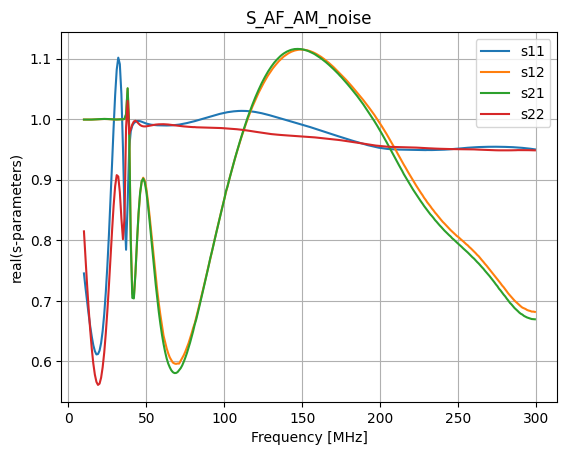

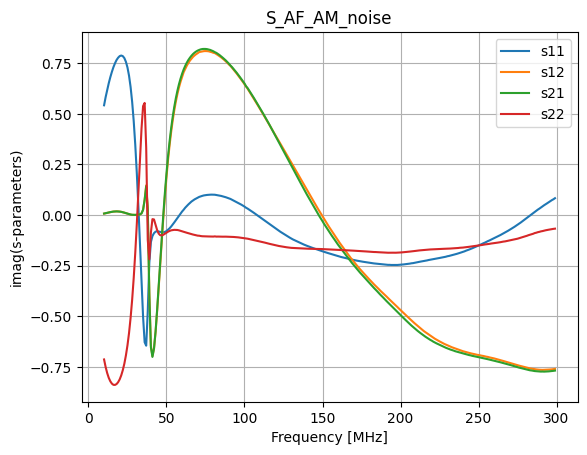

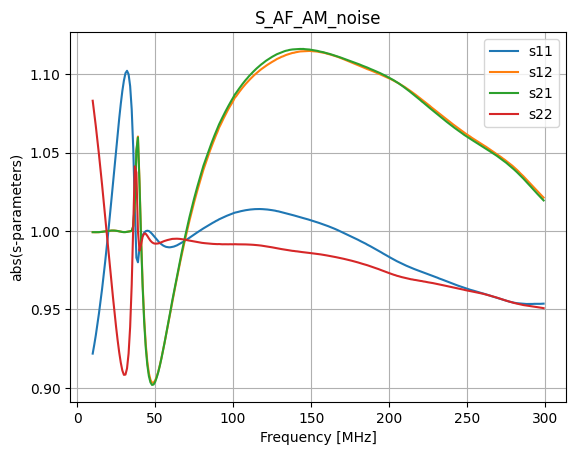

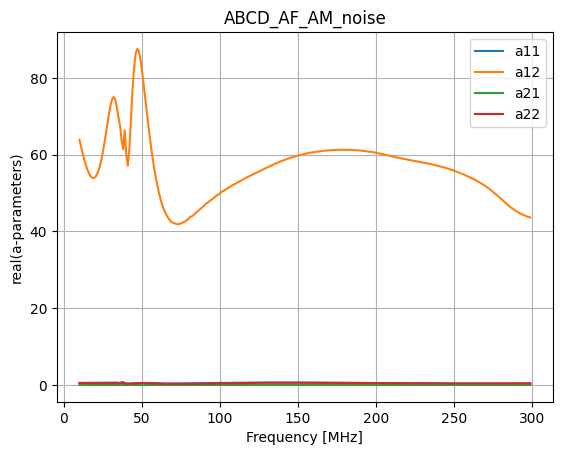

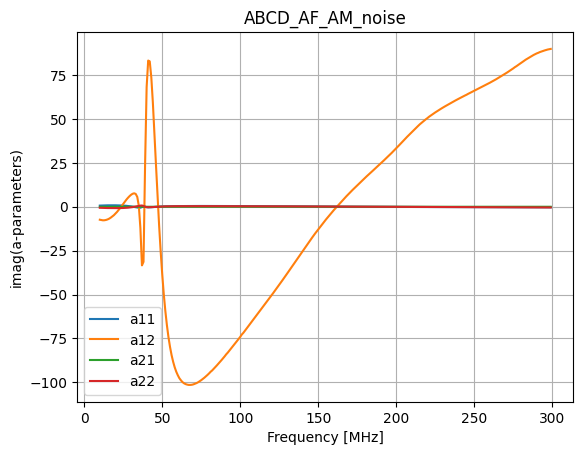

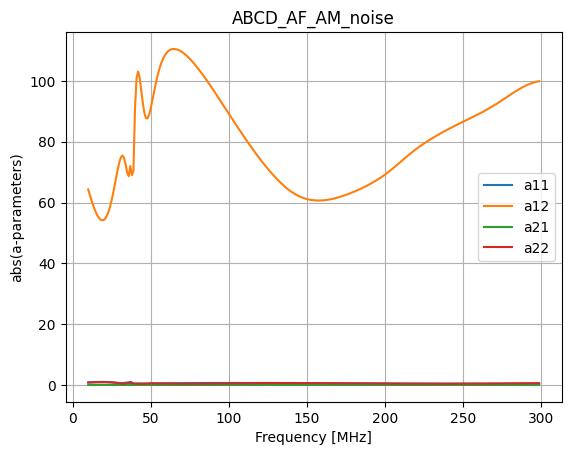

In [6]:
plotSmatrix(S_AF_AM_noise,title='S_AF_AM_noise')
plotABCDmatrix(ABCD_AF_AM_noise,title='ABCD_AF_AM_noise')

- Calculate the Load impedance providing the .s1p file of the element. 

In [7]:
Zload=Load_impedance("S_balun_AD.s1p")

- Calculate the ADC impedance using Zload and ABCD_balun2 matrix (a11, a12, a21, a22)
- Zload = (a11 * Z_ADC + a12) / (a21 * Z_ACD + a22) --> Z_ADC = (a12 - Zload * a22)/(Zload * a21 - a11)

In [116]:
Z_ADC = (ABCD_balun2[:,0,1] - Zload*ABCD_balun2[:,1,1]) / (Zload1*ABCD_balun2[:,1,0] - ABCD_balun2[:,0,0]) 

- Read the antenna impedance for X, Y, Z arms using "Ant_impedance(filename)" providing the antenna impedance file (eg: Z_ant_3.2m.csv)  

- The antenna impedance file format is as follows:
- "Freq [MHz]","re(Z(1,1))","im(Z(1,1))","re(Z(2,2))","im(Z(2,2))","re(Z(3,3))","im(Z(3,3))"

In [117]:
ZantX, ZantY, ZantZ = Ant_impedance("Z_ant_3.2m.csv")

Plot impedance 

In [118]:
#plotImpedance(Z_ADC,title='Z_ADC')
#plotImpedance(Zload,title='Zload')
#plotImpedance(ZantX,title='ZantX')
#plotImpedance(ZantY,title='ZantY')
#plotImpedance(ZantZ,title='ZantZ')

- Compute the ABCD matrix of two or more elements using matix multiplication, e.g. A_tot= A1 * A2 * ...
- Convert it to S-matrix of two or more elements using the function from_ABCD_to_S(ABCD_matrix,Z0=50)
- The ABCD matrix and the S-matrix of the full chain is 

In [125]:
ABCD_tot=np.matmul(np.matmul(np.matmul(np.matmul(np.matmul(ABCD_balun1,ABCD_matching_network_Z),ABCD_LNA),ABCD_cable),ABCD_vga),ABCD_balun2)

In [126]:
Smatrix_tot=from_ABCD_to_S(ABCD_tot,50)

In [121]:
#ABCD_tot=from_S_to_ABCD(Smatrix_tot,50,50)

- Finally compute the Transfer functions (TF) of an element (or the full chain) using the function 
- from_S_to_TF(S_matrix,Zload,Zant,Z01=50,Z02=50) 

In [127]:
VoutZ=from_S_to_TF(Smatrix_tot,Z_ADC,ZantZ,50,50)

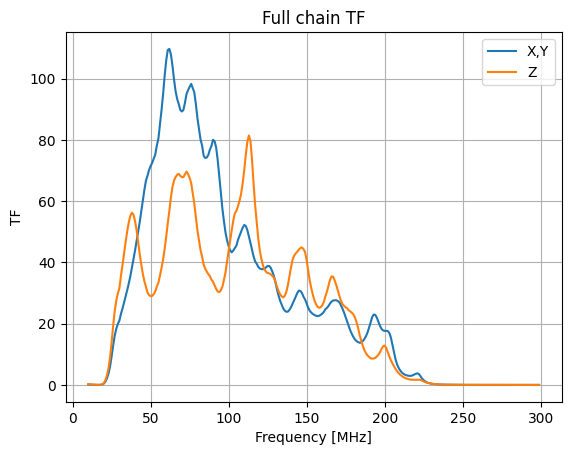

In [132]:
plt.plot(freq_MHz, np.abs(Vout))
plt.plot(freq_MHz, np.abs(VoutZ))
plt.grid()
plt.title("Full chain TF")
plt.legend(['X,Y','Z'])
plt.xlabel('Frequency [MHz]')
plt.ylabel('TF')
plt.show() 